In [39]:
## By A. Zandi
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
## this sets some style parameters
sns.set()

In [40]:
import sqlite3 as sq3

In [41]:
# Download the CSV files
!wget https://raw.githubusercontent.com/opencasestudies/ocs-bp-opioid-rural-urban/master/data/simpler_import/county_pop_arcos.csv
!wget https://raw.githubusercontent.com/opencasestudies/ocs-bp-opioid-rural-urban/master/data/simpler_import/land_area.csv
!wget https://raw.githubusercontent.com/opencasestudies/ocs-bp-opioid-rural-urban/master/data/simpler_import/county_annual.csv

--2025-02-18 05:58:10--  https://raw.githubusercontent.com/opencasestudies/ocs-bp-opioid-rural-urban/master/data/simpler_import/county_pop_arcos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771268 (2.6M) [text/plain]
Saving to: ‘county_pop_arcos.csv.2’

county_pop_arcos.cs 100%[===================>]   2.64M  --.-KB/s    in 0.05s   

2025-02-18 05:58:10 (57.6 MB/s) - ‘county_pop_arcos.csv.2’ saved [2771268/2771268]

--2025-02-18 05:58:10--  https://raw.githubusercontent.com/opencasestudies/ocs-bp-opioid-rural-urban/master/data/simpler_import/land_area.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.1

In [42]:
# Create SQLite database connection
con = sq3.connect("opioid.db")

# Read CSV files into Pandas DataFrames
df_county_pop = pd.read_csv("county_pop_arcos.csv")
df_land_area = pd.read_csv("land_area.csv")
df_county_annual = pd.read_csv("county_annual.csv")

# Write DataFrames to SQLite tables
df_county_pop.to_sql("county_pop_arcos", con, if_exists="replace", index=False)
df_land_area.to_sql("land_area", con, if_exists="replace", index=False)
df_county_annual.to_sql("county_annual", con, if_exists="replace", index=False)

# Close the connection
con.close()
print("SQLite database 'opioid.db' created successfully with tables.")

SQLite database 'opioid.db' created successfully with tables.


In [43]:
# Reconnect to SQLite database
con = sq3.connect("opioid.db")

# Read data into Pandas DataFrames
df_county_pop = pd.read_sql_query("SELECT * FROM county_pop_arcos", con)
df_land_area = pd.read_sql_query("SELECT * FROM land_area", con)
df_county_annual = pd.read_sql_query("SELECT * FROM county_annual", con)

# Close the connection
con.close()

# Display first few rows of each DataFrame
print("County Population Data:\n", df_county_pop.head())
print("\nLand Area Data:\n", df_land_area.head())
print("\nCounty Annual Data:\n", df_county_annual.head())

County Population Data:
    Unnamed: 0 BUYER_COUNTY BUYER_STATE  countyfips  STATE  COUNTY county_name  \
0           1      AUTAUGA          AL        1001      1       1     Autauga   
1           2      BALDWIN          AL        1003      1       3     Baldwin   
2           3      BARBOUR          AL        1005      1       5     Barbour   
3           4         BIBB          AL        1007      1       7        Bibb   
4           5       BLOUNT          AL        1009      1       9      Blount   

                      NAME    variable  year  population  
0  Autauga County, Alabama  B01003_001  2006       51328  
1  Baldwin County, Alabama  B01003_001  2006      168121  
2  Barbour County, Alabama  B01003_001  2006       27861  
3     Bibb County, Alabama  B01003_001  2006       22099  
4   Blount County, Alabama  B01003_001  2006       55485  

Land Area Data:
    Unnamed: 0       Areaname  STCOU  LND010190F  LND010190D  LND010190N1  \
0           1  UNITED STATES      0     

In [44]:
## reading database into Pantas.
###con = sq3.connect("opioid.db")

###county_info = pd.read_sql_query("SELECT * from county_info", con)

#close the connection
###con.close
###
###county_info.head()


In [45]:
# Create lookup dictionary for population by (year, countyfips)
county_pop_dict = df_county_pop.set_index(["year", "countyfips"])["population"].to_dict()

# Create lookup dictionary for opioid prescription dosage by (year, countyfips)
opioid_dosage_dict = df_county_annual.set_index(["year", "countyfips"])["DOSAGE_UNIT"].to_dict()


In [46]:
# compute per capita pills
opioid_pills_per_capita = []  # Store calculated values

for index, row in df_county_annual.iterrows():
    key = (row["year"], row["countyfips"])  # Key for lookup
    population = county_pop_dict.get(key, None)  # Get population if available

    if population and population > 0:  # Avoid division by zero
        per_capita = row["DOSAGE_UNIT"] / population
    else:
        per_capita = None  # Assign None if population is missing

    opioid_pills_per_capita.append(per_capita)

df_county_annual["opioid_pills_per_capita"] = opioid_pills_per_capita


In [47]:
# Compute annual average
df_yearly_avg = df_county_annual.groupby("year")["opioid_pills_per_capita"].mean().reset_index()
df_yearly_avg.rename(columns={"opioid_pills_per_capita": "avg_pills_per_capita"}, inplace=True)

print("Computed Yearly Averages:\n", df_yearly_avg.head())


Computed Yearly Averages:
    year  avg_pills_per_capita
0  2006             28.783799
1  2007             32.474087
2  2008             35.503895
3  2009             39.094975
4  2010             41.532509


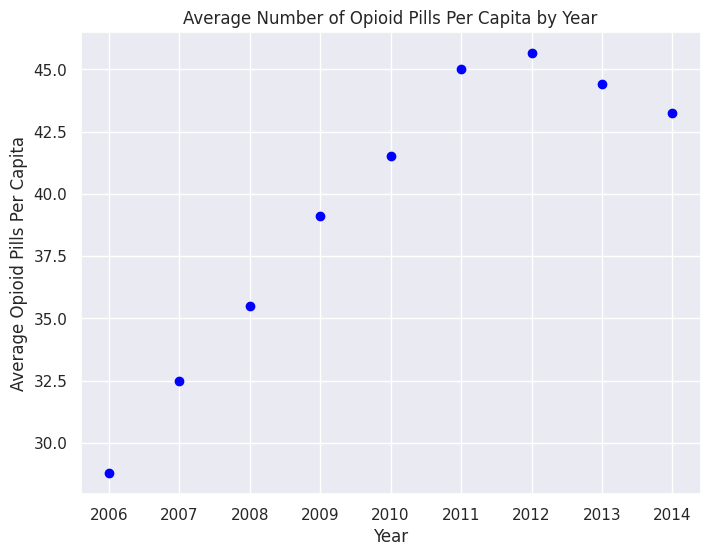

In [48]:
# Scatter Plot
import matplotlib.pyplot as plt

# Scatter plot of average opioid pills per capita per year
plt.figure(figsize=(8,6))
plt.scatter(df_yearly_avg["year"], df_yearly_avg["avg_pills_per_capita"], color='blue')
plt.xlabel("Year")
plt.ylabel("Average Opioid Pills Per Capita")
plt.title("Average Number of Opioid Pills Per Capita by Year")
plt.grid(True)
plt.show()


In [3]:
import pandas as pd

# GitHub raw URL
github_url = "https://raw.githubusercontent.com/bitcon1/my-first-repo/master/HWK4/opioid_yearly_avg.csv"

# Load the dataset from GitHub
df_yearly_avg = pd.read_csv(github_url)

# Display the first few rows
print(df_yearly_avg.head())


   year  avg_pills_per_capita
0  2006             28.783799
1  2007             32.474087
2  2008             35.503895
3  2009             39.094975
4  2010             41.532509
